### In this notebook, I try to add stellar mass and redshift into $\vec{\theta}$, plus noise into the data and forward models

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, Photulator, StandardScaler

In [6]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)
speculator._build_params_prior()
speculator.bounds = [speculator.prior[key] for key in speculator.params_name]
speculator.network.eval();

In [32]:
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [41]:
# y_data = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=5000)
# y_data = np.random.multivariate_normal(mean=[6, 0], cov=[[1, 0], [0, 1]], size=5000)
y_data1 = np.random.multivariate_normal(mean=[6, -1], cov=[[0.7, 0.], [0., 0.2]], size=2500)
y_data2 = np.random.multivariate_normal(mean=[5, 1.5], cov=[[0.7, 0.], [0., 0.3]], size=2500)
#y_data2 = np.random.multivariate_normal(mean=[6, 0], cov=[[-0.7, 0.3], [0.3, -0.1]], size=1500)
y_data = np.vstack([y_data1, y_data2])
y_data = Tensor(y_data).to('cuda')

y_stellar_mass = torch.normal(10, 0.4, size=(len(y_data), 1)).to('cuda')

# _temp = torch.distributions.MultivariateNormal(torch.Tensor([10.5, 0.15]), 
#                                                covariance_matrix=torch.Tensor([[0.3, 0.1], 
#                                                                                [-0.02, 0.005]]))
# _smp = _temp.sample(torch.Size([5000,]))
# y_stellar_mass = _smp[:, 0][:, None].to('cuda')
# y_redshift = _smp[:, 1][:, None].to('cuda')
# y_stellar_mass = torch.vstack([torch.normal(10, 0.4, size=(len(y_data) // 2, 1)).to('cuda'),
#                                torch.normal(11.5, 0.4, size=(len(y_data) // 2, 1)).to('cuda')])
# y_redshift = torch.normal(0.15, 0.03, size=(len(y_data), 1)).to('cuda')
y_redshift = torch.vstack([torch.normal(0.08, 0.015, size=(len(y_data) // 2, 1)),
                           torch.normal(0.14, 0.015, size=(len(y_data) // 2, 1))]).to('cuda')

In [42]:
from sklearn.utils import shuffle
y_data = shuffle(y_data, random_state=10)
y_stellar_mass = shuffle(y_stellar_mass, random_state=1)
y_redshift = shuffle(y_redshift, random_state=0)

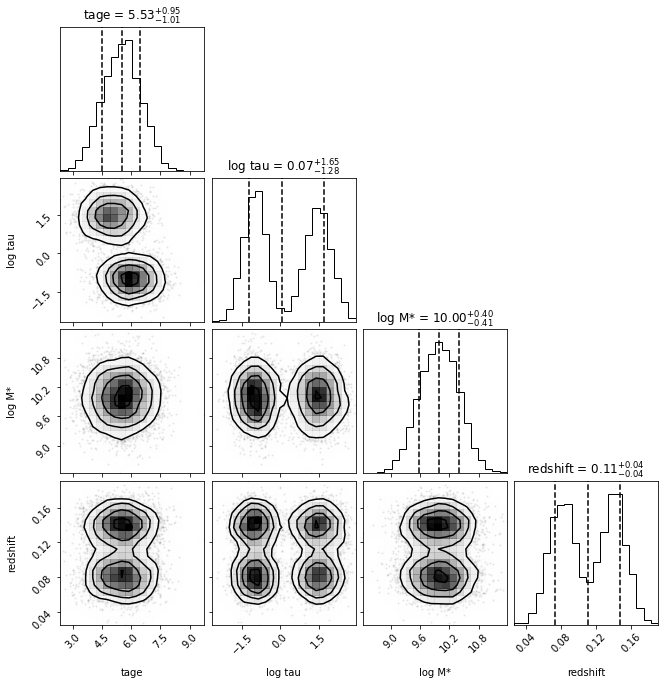

In [43]:
X_data = speculator.predict_mag(y_data, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=noise, noise_model_dir=noise_model_dir,
                               ).cpu().detach().numpy()
X_data = Tensor(X_data).to('cuda')
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
X_data = X_data[flag]
y_data = y_data[flag]
y_stellar_mass = y_stellar_mass[flag]
y_redshift = y_redshift[flag]

_X_data_clean = speculator.predict_mag(y_data, 
                                log_stellar_mass=y_stellar_mass, 
                                redshift=y_redshift,
                                filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
                                noise=None,
                               ).cpu().detach().numpy()
_X_data_clean = Tensor(_X_data_clean).to('cuda')
_X_data_clean = _X_data_clean[~torch.isnan(_X_data_clean).any(dim=1)]

figure = corner.corner(np.hstack([y_data.cpu().detach().numpy(), 
                                  y_stellar_mass.cpu().detach().numpy(),
                                  y_redshift.cpu().detach().numpy()]), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log M*', 'redshift'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
Y_truth = torch.hstack([y_data, y_stellar_mass, y_redshift])

In [46]:
X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth, test_size=0.2, random_state=42)

### We try to achieve our goal with loss = Sinkhorn(X, Y), where X is the observed SED, and Y is the model output.

In [48]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss
#del NDE_theta, samples

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf', num_transforms=5, # 10, 
                                              num_bins=20, 
                                              hidden_features=50, # 120, 
                                              output_dir=None, 
#                                               initial_pos={'mean': [6, 3, 10.0, 0.05], 'std': [1, 1, 1, 0.05]},
                                              initial_pos={'mean': [5, 1, 10.5, 0.15], 'std': [1, 1, 1, 0.03]},
                                              normalize=False)
NDE_theta.build(
    Y_train,
    X_train,
    optimizer='adam')

NDE_theta.load_validation_data(X_vali, Y_vali)

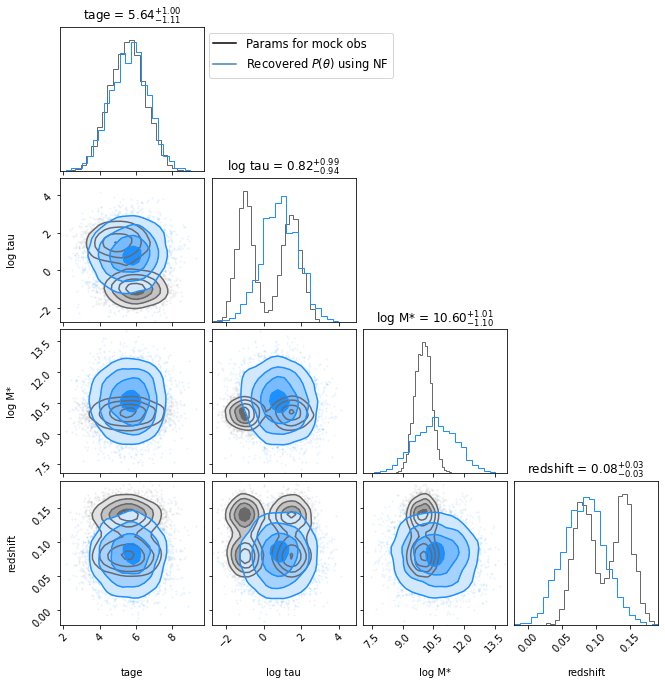

In [49]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [20]:
max_epochs = 4
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=3e-3, 
                                                steps_per_epoch=100, 
                                                epochs=max_epochs)

In [21]:
for epoch in range(max_epochs):
    print('lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    NDE_theta.train(n_epochs=100, n_samples=3000,
                    speculator=speculator, 
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={'p': 1, 'blur': 0.1, 'scaling': 0.5},
                    scheduler=scheduler
                   )
    #scheduler.step()

lr: 0.00011999999999999988


Loss = 0.046 (train), 0.054 (vali): 100%|█████████████████████████| 100/100 [00:24<00:00,  4.08epochs/s]


lr: 0.00282261348773947


Loss = 0.043 (train), 0.063 (vali): 100%|█████████████████████████| 100/100 [00:24<00:00,  4.08epochs/s]


lr: 0.0024220202310030396


Loss = 0.042 (train), 0.060 (vali): 100%|█████████████████████████| 100/100 [00:23<00:00,  4.19epochs/s]


lr: 0.0008340610677446612


Loss = 0.039 (train), 0.062 (vali): 100%|█████████████████████████| 100/100 [00:24<00:00,  4.11epochs/s]


In [50]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [51]:
for i in range(8):
    NDE_theta = WassersteinNeuralDensityEstimator(method='nsf', num_transforms=5, # 10, 
                                                  num_bins=20, hidden_features=50, # 120, 
                                                  initial_pos={'mean': [5, 1, 10.5, 0.2], 
                                                               'std': [1, 1, 1, 0.03]},
                                                  normalize=False, 
                                                  output_dir='./nde_theta_four_peak/')
    NDE_theta.build(
        Y_train,
        X_train,
        optimizer='adam')

    NDE_theta.load_validation_data(X_vali, Y_vali)
    max_epochs = 4
    scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                    max_lr=3e-3, 
                                                    steps_per_epoch=100, 
                                                    epochs=max_epochs)

    for epoch in range(max_epochs):
        print('lr:', NDE_theta.optimizer.param_groups[0]['lr'])
        NDE_theta.train(n_epochs=100, n_samples=5000,
                        speculator=speculator, 
                        noise=noise, noise_model_dir=noise_model_dir,
                        sinkhorn_kwargs={'p': 1, 'blur': 0.05, 'scaling': 0.5},
                        scheduler=scheduler
                       )

lr: 0.00011999999999999988


Loss = 0.111 (train), 0.128 (vali): 100%|█████████████████████████| 100/100 [00:35<00:00,  2.85epochs/s]


lr: 0.00282261348773947


Loss = 0.103 (train), 0.128 (vali): 100%|█████████████████████████| 100/100 [00:36<00:00,  2.77epochs/s]


lr: 0.0024220202310030396


Loss = 0.048 (train), 0.093 (vali): 100%|█████████████████████████| 100/100 [00:41<00:00,  2.42epochs/s]


lr: 0.0008340610677446612


Loss = 0.048 (train), 0.088 (vali): 100%|█████████████████████████| 100/100 [00:40<00:00,  2.49epochs/s]


lr: 0.00011999999999999988


Loss = 0.044 (train), 0.080 (vali): 100%|█████████████████████████| 100/100 [00:42<00:00,  2.37epochs/s]


lr: 0.00282261348773947


Loss = 0.040 (train), 0.078 (vali): 100%|█████████████████████████| 100/100 [00:43<00:00,  2.32epochs/s]


lr: 0.0024220202310030396


Loss = 0.034 (train), 0.082 (vali): 100%|█████████████████████████| 100/100 [00:34<00:00,  2.86epochs/s]


lr: 0.0008340610677446612


Loss = 0.033 (train), 0.074 (vali): 100%|█████████████████████████| 100/100 [00:35<00:00,  2.86epochs/s]


lr: 0.00011999999999999988


Loss = 0.038 (train), 0.073 (vali): 100%|█████████████████████████| 100/100 [00:44<00:00,  2.27epochs/s]


lr: 0.00282261348773947


Loss = 0.034 (train), 0.066 (vali): 100%|█████████████████████████| 100/100 [00:42<00:00,  2.34epochs/s]


lr: 0.0024220202310030396


Loss = 0.033 (train), 0.069 (vali): 100%|█████████████████████████| 100/100 [00:36<00:00,  2.74epochs/s]


lr: 0.0008340610677446612


Loss = 0.034 (train), 0.068 (vali): 100%|█████████████████████████| 100/100 [00:39<00:00,  2.55epochs/s]


lr: 0.00011999999999999988


Loss = 0.039 (train), 0.079 (vali): 100%|█████████████████████████| 100/100 [00:39<00:00,  2.51epochs/s]


lr: 0.00282261348773947


Loss = 0.028 (train), 0.062 (vali): 100%|█████████████████████████| 100/100 [00:45<00:00,  2.21epochs/s]


lr: 0.0024220202310030396


Loss = 0.024 (train), 0.059 (vali): 100%|█████████████████████████| 100/100 [00:38<00:00,  2.61epochs/s]


lr: 0.0008340610677446612


Loss = 0.023 (train), 0.072 (vali): 100%|█████████████████████████| 100/100 [00:40<00:00,  2.48epochs/s]


lr: 0.00011999999999999988


Loss = 0.156 (train), 0.202 (vali): 100%|█████████████████████████| 100/100 [00:35<00:00,  2.82epochs/s]


lr: 0.00282261348773947


Loss = 0.055 (train), 0.082 (vali): 100%|█████████████████████████| 100/100 [00:41<00:00,  2.42epochs/s]


lr: 0.0024220202310030396


Loss = 0.035 (train), 0.072 (vali): 100%|█████████████████████████| 100/100 [00:56<00:00,  1.76epochs/s]


lr: 0.0008340610677446612


Loss = 0.030 (train), 0.078 (vali): 100%|█████████████████████████| 100/100 [00:52<00:00,  1.90epochs/s]


lr: 0.00011999999999999988


Loss = 0.085 (train), 0.087 (vali): 100%|█████████████████████████| 100/100 [00:38<00:00,  2.58epochs/s]


lr: 0.00282261348773947


Loss = 0.034 (train), 0.082 (vali): 100%|█████████████████████████| 100/100 [00:41<00:00,  2.42epochs/s]


lr: 0.0024220202310030396


Loss = 0.027 (train), 0.071 (vali): 100%|█████████████████████████| 100/100 [00:41<00:00,  2.38epochs/s]


lr: 0.0008340610677446612


Loss = 0.029 (train), 0.070 (vali): 100%|█████████████████████████| 100/100 [00:40<00:00,  2.47epochs/s]


lr: 0.00011999999999999988


Loss = 0.059 (train), 0.093 (vali): 100%|█████████████████████████| 100/100 [00:40<00:00,  2.45epochs/s]


lr: 0.00282261348773947


Loss = 0.062 (train), 0.103 (vali): 100%|█████████████████████████| 100/100 [00:38<00:00,  2.62epochs/s]


lr: 0.0024220202310030396


Loss = 0.055 (train), 0.112 (vali): 100%|█████████████████████████| 100/100 [00:34<00:00,  2.88epochs/s]


lr: 0.0008340610677446612


Loss = 0.057 (train), 0.101 (vali): 100%|█████████████████████████| 100/100 [00:35<00:00,  2.81epochs/s]


lr: 0.00011999999999999988


Loss = 0.039 (train), 0.088 (vali): 100%|█████████████████████████| 100/100 [00:41<00:00,  2.42epochs/s]


lr: 0.00282261348773947


Loss = 0.030 (train), 0.064 (vali): 100%|█████████████████████████| 100/100 [00:47<00:00,  2.09epochs/s]


lr: 0.0024220202310030396


Loss = 0.027 (train), 0.070 (vali): 100%|█████████████████████████| 100/100 [00:40<00:00,  2.44epochs/s]


lr: 0.0008340610677446612


Loss = 0.027 (train), 0.061 (vali): 100%|█████████████████████████| 100/100 [00:36<00:00,  2.72epochs/s]


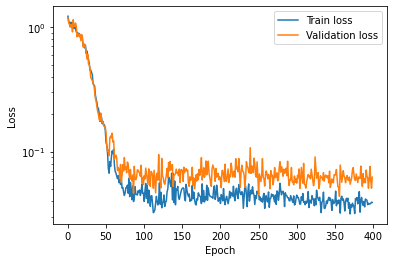

In [22]:
NDE_theta.plot_loss()
plt.yscale('log')

In [31]:
Y = NDE_theta.scaler.transform(
    speculator._predict_mag_with_mass_redshift(
        NDE_theta.sample(2988))
)
# bad_ratio = (torch.isnan(Y).any(dim=1).sum() +
#              torch.isinf(Y).any(dim=1).sum()) / len(Y)
# val = 20.0
# Y = torch.nan_to_num(Y, val, posinf=val, neginf=-val)
# Y = Y[~(torch.isinf(Y).any(dim=1) | torch.isnan(Y).any(dim=1))]
# Y = torch.nan_to_num(Y, 0.0, posinf=0.0, neginf=-.0)

In [32]:
L = SamplesLoss(loss="sinkhorn", p=1, scaling=0.8)

In [33]:
L(NDE_theta.X, Y)

tensor(0.2812, device='cuda:0', grad_fn=<SelectBackward0>)

In [169]:
NDE_theta.train_loss_history[np.argmin(NDE_theta.vali_loss_history)]

0.03654836118221283

In [23]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

Best epoch: 371
Best train loss: 0.031591691076755524
Best vali loss: 0.0547058992087841


In [24]:
NDE_theta.goodness_of_fit(Y_truth, p=1)

Log10 Wasserstein distance in theta space:  -0.4962641681479961


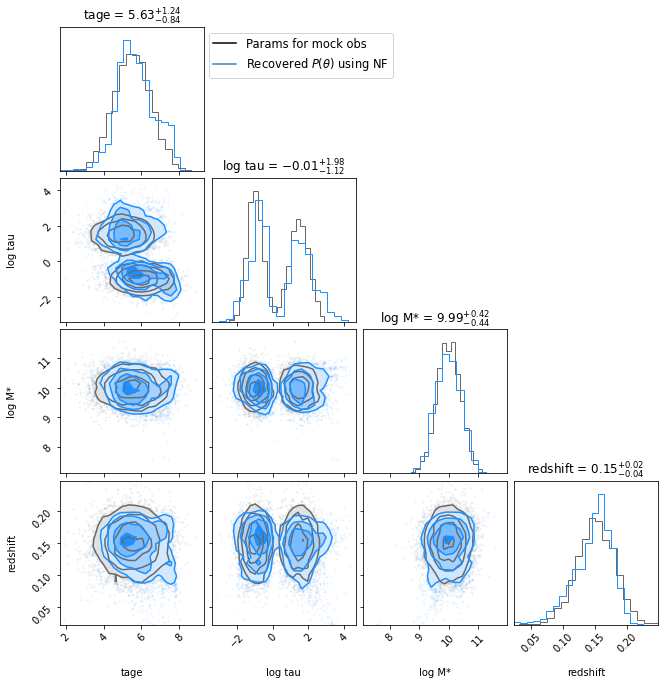

In [25]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Recovered $P(\theta)$ using NF')

labels = ['tage', 'log tau', 'log M*', 'redshift']

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=20,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.5, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=20,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('With noise')

9 5000


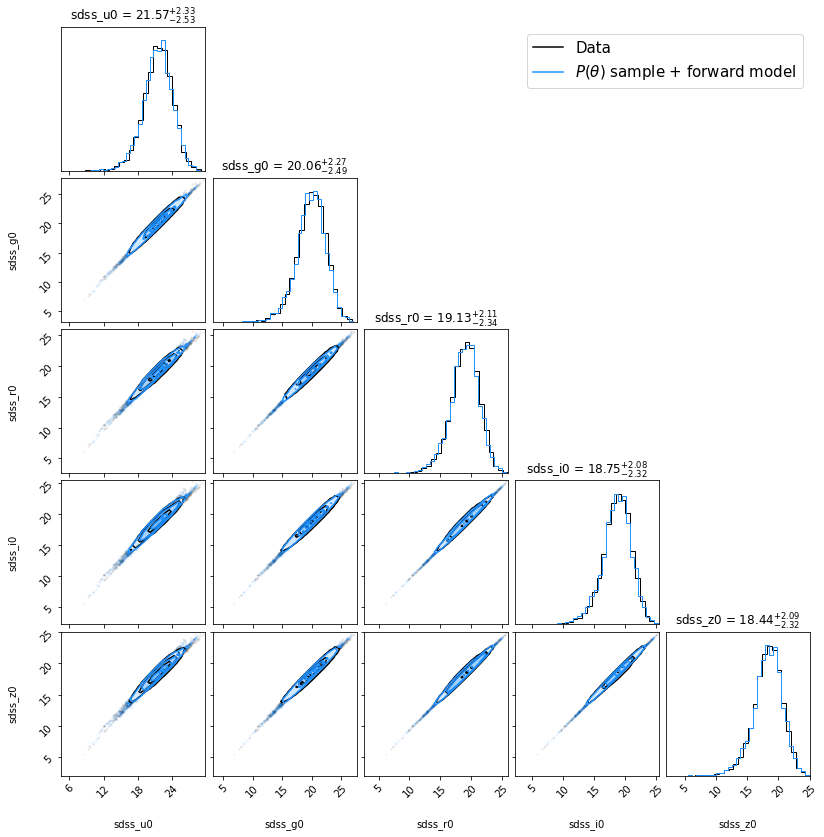

In [207]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [f'sdss_{f}0' for f in 'ugriz']

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(samples,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [151]:
from geomloss import SamplesLoss

In [149]:
Y = NDE_theta.scaler.transform(
    speculator._predict_mag_with_mass_redshift(
        NDE_theta.sample(3938))
)
bad_mask = (torch.isnan(Y).any(dim=1) | torch.isinf(Y).any(dim=1))
bad_ratio = bad_mask.sum() / len(Y)
Y = Y[~bad_mask]

In [157]:
L = SamplesLoss(loss="sinkhorn", p=1, scaling=0.5, blur=0.01)

In [158]:
torch.log10(L(NDE_theta.X, Y))

tensor(-1.5337, device='cuda:0', grad_fn=<SubBackward0>)

In [160]:
torch.log10(L(NDE_theta.X[:, 0:1], Y[:, 0:1]))

tensor(-2.4295, device='cuda:0', grad_fn=<Log10Backward0>)

In [163]:
torch.log10(L(NDE_theta.X[:, 1:4], Y[:, 1:4]))

tensor(-1.8993, device='cuda:0', grad_fn=<Log10Backward0>)

In [67]:
speculator.bounds

[[0, 13], [-3, 3]]